In [1]:
import numpy as np
import pandas as pd
import math
from src.hdmm.error import expected_error, strategy_supports_workload
from src.hdmm.matrix import EkteloMatrix

from matplotlib import pyplot as plt
from collections import OrderedDict
from src.hdmm.workload import AllRange

In [2]:
pd.set_option('display.float_format', '{:0.2f}'.format)

In [3]:
def getBounds(df):
    """
    Returns [upper bound error, lower bound error]
    """
    return [df.abs_error.min(), df.abs_error.max()]

def getAverageError(df):
    """
    Returns average error across all queries
    """
    return df.abs_error.sum() / len(df)

def printBoundsAndAvgError(df):
    print(f'Average error is {getAverageError(df)}. Lower bound is {getBounds(df)[0]} and upper bound is {getBounds(df)[1]}')

In [74]:
def pmw2(workload, x, T, eps=0.01, k=0, analyst_labels = [], 
         show_messages=True, to_return='pd', show_plot=False, show_failure_step=True):
    """
    Implement Private Multiplicative Weights Mechanism (PMW) on a workload of
    linear queries. 

    Algorithm Parameters: 
    - workload = workload of queries (M x k numpy array)
    - x = true database (M x 1 numpy array)
    - T = update threshold
    - eps = privacy budget
    - k = number of update steps PER ANALYST
    - analyst_labels = list of analyst names corresponding to each query in the workload
    
    Output Controls: 
    - show_messages argument determines whether the function will print information such as 
    error scale, threshold, update steps used, etc.
    - to_return argument determines what the function will return. 
        - if 'pd', pmw() returns pandas df with test data for each 
        query in the workload(showing query, d_t_hat, updated, algo_ans, real_ans, 
        abs_error, rel_error). 
        - if 'update_count', pmw() returns the update count for the total
        amount of queries.
    - show_plot - T/F whether the function will display a plot
    - show_failure_step - T/F whether function prints what step failure mode is reached
    """ 
    
    update_steps = {}
    for analyst in list(set(analyst_labels)): 
        update_steps[analyst] = k # each analyst starts with k update steps
    
    # initialize constants
    m = x.size  # database len
    n = x.sum()
    eta = (math.log(m, np.e) ** (1 / 4)) / (math.sqrt(n))
    delta = 1 / (n * math.log(n, np.e))
    x_norm = x / np.sum(x)
    
    # initialize synthetic databases at time 0 (prior to any queries)
    x_t = np.ones(m) / m
    y_t = np.ones(m) / m

    # initialize tracker lists to construct pandas dataframe at the end 
    x_list = [x_t] # create a list of x_t synthetic database at every time step
    update_list = []
    update_count = 0
    pmw_answers = []
    update_times = [] # record times that database is updated
    d_t_hat_list = []
    
    def lazy_round():
        """
        "Lazy Round" of querying using the stored synthetic database, x_t, in list x_list.
        
        We call this the lazy round because it is contrasted with the updated step where we update the 
        sythetic database and answer the query using the real database.
        """
        update_list.append('no')
        pmw_answers.append(np.dot(query, x_list[time]))
        x_list.append(x_list[time].round(3))
    
    # inititate first instance of SVT with half the budget and k updates; will be reset in the main loop
    SVTtrigger = False 
    SVTepsilon1 = ((eps/2)/2)
    SVTepsilon2 = ((eps/2)/2)
    rho = np.random.laplace(loc=0, scale=(1/SVTepsilon1), size=1)[0]
    
    for time, query in enumerate(workload):
        
        analyst = analyst_labels[time]
        
        # Do one round of sparse vector technique 
        
        # Compute noisy answer by adding Laplacian noise
        a_t = np.random.laplace(loc=0, scale=(2*k/SVTepsilon2), size=1)[0]
        a_t_hat = (np.dot(query, x_norm)*n ) + a_t

        # Difference between noisy and maintained histogram answer
        d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
        
        # Lazy round: use synthetic base to answer the query
        if (abs(d_t_hat) <= T + rho):
            d_t_hat_list.append(d_t_hat)
            lazy_round()
            continue

        # update round: update histogram and return noisy answer
        else:
            #make a new noisy query answer using some of the leftover budget
            a_t = np.random.laplace(loc=0, scale=(2*k/eps), size=1)[0]
            a_t_hat = (np.dot(query, x_norm)*n ) + a_t
            d_t_hat = a_t_hat - (n*np.dot(query, x_list[time]))
            d_t_hat_list.append(d_t_hat)
            update_times.append(time)
            
            # step a
            if d_t_hat < 0:
                r_t = query
            else:
                r_t = np.ones(m) - query
            for i, v in enumerate(y_t):
                y_t[i] = x_list[time][i] * math.exp((d_t_hat/(2*n)) * query[i]) * 20 # 20 is the learning rate
            
            # step b
            x_t = y_t / np.sum(y_t)
            update_count = update_list.count('yes')
            
            # if threshold for num updates is reached, just do a lazy round (synthetic database) answer
            if update_steps[analyst] == 0: 
                if show_failure_step:
                    print(f'Failure mode reached at query number {time}: {query}')
                lazy_round()
                
            # if there are still update steps that the analyst can use, 
            # 1. update the synthetic database
            # 2. answer the query using the noisy answer from the database itself 
            else: 
                x_list.append(x_t.round(3))
                update_list.append('yes') # increment number of updates counter
                pmw_answers.append(a_t_hat / np.sum(x))
                update_steps[analyst] -= 1 # use one of analyst's update steps

    update_count = update_list.count('yes')      

    # calculate error
    real_ans = np.matmul(workload, x_norm)
    abs_error = np.abs(pmw_answers - real_ans)
    rel_error = np.abs(abs_error / np.where(real_ans == 0, 0.000001,
                                                real_ans))
    
    if show_messages:
        np.set_printoptions(suppress=True)
        """Print inputes/outputs to analyze each query"""
        print(f'Original database: {x}\n')
        print(f'Normalized database: {x_norm}\n')
        print(f'Updated Database = {x_t}\n')
        print(f'Update Count = {update_count}\n')
        print(f'{T=}\n')
        print(f'Error Scale Query Answer= {2*((2*k/eps)**2)}\n')
        print(f'Error Scale SVT= {2*((2*k/SVTepsilon2)**2)}\n')
        print(f'Update Parameter Scale = {eta}\n')
        print(f'{delta=}\n')
        
    if show_plot: 
        plt.title('Error across queries:')
        rel_line, = plt.plot(rel_error, label='Relative Error')
        abs_line, = plt.plot(abs_error, label='Absolute Error')
        for xc in update_times:
            plt.axvline(x=xc, color='red', label='Update Times', linestyle='dashed')
        plt.legend(handles=[abs_line,rel_line])
        plt.xticks(range(0, len(workload), round(len(workload)/5)))
    
    if to_return == "pd":
        # hacky fix: remove the first synthetic database to keep length of lists consistent with the
        # other lists that comprise of the pandas dataframe
        x_list.pop(0).tolist() 
        d = {
            'algo_ans': pmw_answers,
            'real_ans': real_ans.tolist(),
            'queries': workload.tolist(), 
            'updated': update_list,
            'abs_error': abs_error,               
            'rel_error': rel_error,
            'synthetic database': x_list,
            'analyst': analyst_labels,
            'd_t_hat': d_t_hat_list, 

             }
        test_data = pd.DataFrame(data=d)
        test_data = test_data.round(3)
        return test_data
    
    # return dictionary of absolute errors
    if to_return == "error":
        d = {'analyst': analyst_labels,
             'abs_error': abs_error,               
             'rel_error': rel_error,}
        data = pd.DataFrame(data=d)
        data = data.round(3)
        
        analyst_error = {}
        for analyst in list(set(analyst_labels)):
            analyst_error[analyst] = data[data.analyst==analyst]['abs_error'].sum()
        return analyst_error

In [75]:
pmw2(workload=np.vstack((s1alice_q, s1bob_q)), x=x_small, eps=2, T=40, k=10,  
                                 analyst_labels=['Alice'] * 25 + ['Bob'] * 25, 
                                 to_return='error', show_plot=False, show_messages=False, show_failure_step=False)

{'Alice': 1.175, 'Bob': 1.6260000000000003}

### Initializing workloads and databases

In [5]:
x_small = np.array([20, 160, 20, 20, 20, 160, 20, 20])
normalized = x_small / x_small.sum()
m = x_small.size  # database len
n = x_small.sum()
#print(f'the threshold for failure is {n * math.log(m, np.e) ** (1 / 2)}')

random_array = np.random.randint(2, size=(500,4))
zero_array = np.zeros((500,4))
alice = np.hstack((random_array, zero_array))
bob = np.hstack((zero_array, random_array))

We've shown that Alice can use up all the privacy budget. 

Next, let's take some of the basic adaptations of pmw and see if we can get the same effects to happen or a similar effect were people get similar results indpenedently

### To Dos: 

Instead of having a communal pool of update steps we can do, split the amount of update steps evenly across all analysts. If your update steps are not a multiple of the analysts, you can change the number of update steps.  

Look for the same kind of violation where either Bob or Alice will have more overall error in the joint case as opposed to the independent case.

In the independent state, you can use the existing pmw algorihtm.

Suggestion: When you split it to their individual settings, give them the same amount of update steps that they would've gotten in the group. 

Individually - 1 ep, 5 k. together - 2 ep, 10k. 

### Experiments: 
Try original pmw, adapted w equal update steps pmw, individual: 
1. [done] A and B query disjoint sections
2. [done] A queries the entire dataset except for last index. B queries entire dataset, last index inclusive. 
3. [done] A asks singleton, B asks all range queries
4. [if time] Is total error the right metric? Context: You might run into a case where you get flat error across all of your queries. You may get a lot worse error on one specific query, but the overall error is better. Now Alice and Bob care about the same data. Alice eats all the budget (entire database except for last). Bob cares about entire database, but his queries about the last index has higher error. 
    
    
Scenarios to look for: 
1. Regular pmw performs poorly, but adapted pmw works well. (probably in disjoint setting)
2. Scenarios where regular AND adapted pmw perform poorly

## Scenario 1: Disjoint

In [6]:
# initialize
s1random_array = np.random.randint(2, size=(25,4))
s1zero_array = np.zeros((25,4))
s1alice_q = np.hstack((s1random_array, s1zero_array))
s1bob_q = np.hstack((s1zero_array, s1random_array))

s1combined_list = []
s1bobfirst_list = []
s1individual_list = []

for i in range(1000):
    # combined
    s1combined = pmw2(workload=np.vstack((s1alice_q, s1bob_q)), x=x_small, eps=2, T=40, k=10,  
                                 analyst_labels=['Alice'] * 25 + ['Bob'] * 25, 
                                 to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s1combined_list.append(s1combined)
    
    s1bobfirst = pmw2(workload=np.vstack((s1bob_q, s1alice_q)), x=x_small, eps=2, T=40, k=10,  
                                 analyst_labels=['Bob'] * 25 + ['Alice'] * 25, 
                                 to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s1bobfirst_list.append(s1bobfirst)
    
    # individual
    s1a = pmw2(workload=s1alice_q, x=x_small, eps=1, T=40, k=5,
               analyst_labels=['Alice'] * 25, 
               to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s1b = pmw2(workload=s1bob_q, x=x_small, eps=1, T=40, k=5,
               analyst_labels=['Bob'] * 25, 
               to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s1individual = {**s1a, **s1b}
    s1individual_list.append(s1individual)
    
# find mean over multiple trials
s1combined_average = dict(pd.DataFrame(s1combined_list).mean())
s1bobfirst_average = dict(pd.DataFrame(s1bobfirst_list).mean())
s1individual_average = dict(pd.DataFrame(s1individual_list).mean())

d = {'alice_first': s1combined_average, 'individual': s1individual_average, 'bob_first': s1bobfirst_average}
df = pd.DataFrame(data=d).sort_index()
display(df)

,alice_first,individual,bob_first
Alice,1.40,2.02,1.50
Bob,1.49,2.02,1.40


Bob always receives more error in the combined setting than in the individual setting.

Questions: 

1. Why does Bob always receives more error than Alice in the individual setting if their queries are not related? I would expect instead that their individual error would be very similar. **Bob's spike is larger**
    
2. Alice receives substantially more error in the individual setting than the combined setting. Is this supposed to happen? Although she receives less update steps in the individual setting, shouldn't the smaller epsilon value in the inidivual case counteract this effect? **Alice gets more update steps in the combined setting (eats Bob's)**


In [7]:
printBoundsAndAvgError(pmw2(workload=np.vstack((s1alice_q, s1bob_q)), x=x_small, eps=2, T=40, k=10,  
                                 analyst_labels=['Alice'] * 25 + ['Bob'] * 25, 
                                 to_return='pd', show_plot=False, show_messages=False, show_failure_step=False))

Average error is 0.055760000000000004. Lower bound is 0.0 and upper bound is 0.207


We measure average error becauase we want to think about infinite query sequences - the types of sequences that PMW are very good at. Average error is better for longer query sequences. PMW is designed to make guarantees on average error. The error will be less than $\alpha$ with some probability of failure $\beta$.

# Scenario 2: Last Index

In [8]:
s2combined_list = []
s2individual_list = []
s2bobfirst_list = []

for i in range(10):
    # combined
    s2alice_q = np.hstack((np.random.randint(2, size=(25,7)), np.zeros((25,1))))
    s2bob_q = np.random.randint(2, size=(25,8))

    s2combined = pmw2(workload=np.vstack((s2alice_q, s2bob_q)), x=x_small, eps=2, T=40, k=10,  
                                 analyst_labels=['Alice'] * 25 + ['Bob'] * 25, 
                                 to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s2combined_list.append(s2combined)

    
    s2bobfirst = pmw2(workload=np.vstack((s2bob_q, s2alice_q)), x=x_small, eps=2, T=40, k=10,  
                                 analyst_labels= ['Bob'] * 25 + ['Alice'] * 25, 
                                 to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s2bobfirst_list.append(s1bobfirst)
    
    # individual
    s2a = pmw2(workload=s2alice_q, x=x_small, eps=1, T=40, k=5,
               analyst_labels=['Alice'] * 25, 
               to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s2b = pmw2(workload=s2bob_q, x=x_small, eps=1, T=40, k=5,
               analyst_labels=['Bob'] * 25, 
               to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s2individual = {**s2a, **s2b}
    s2individual_list.append(s2individual)

# find mean over multiple trials
s2combined_average = dict(pd.DataFrame(s2combined_list).mean())
s2individual_average = dict(pd.DataFrame(s2individual_list).mean())
s2bobfirst_average = dict(pd.DataFrame(s1bobfirst_list).mean())

d = {'alice_first': s2combined_average, 'individual': s2individual_average, 'bob_first': s2bobfirst_average}
df = pd.DataFrame(data=d).sort_index()
display(df)

,alice_first,individual,bob_first
Alice,2.02,2.86,1.50
Bob,1.64,2.85,1.40


all indices except last -> all indices: 1.29 difference
all indices -> all indices except last: 1.69 difference

Alice is doing better than Bob in the individual and combined setting. 

When Bob goes first, he suffers less error than alice did when she went first. 

**Alice's error** in `bob_first` > **Bob's error** in `alice_first`. This makes the empirical point that if the second person queries less from the dataset than the first person, they face more error than going second if you query more from the dataset than the first person. This doesn't make sense to me. Shouldn't the second person that explores more of the dataset that has been previously unexplored experience more error than the second person in the other scenario that explores less of the dataset that had already been previous explored?

In [9]:
printBoundsAndAvgError(pmw2(workload=np.vstack((s2alice_q, s2bob_q)), x=x_small, eps=2, T=40, k=10,  
                                 analyst_labels=['Alice'] * 25 + ['Bob'] * 25, 
                                 to_return='pd', show_plot=False, show_messages=False, show_failure_step=False))

Average error is 0.06514. Lower bound is 0.0 and upper bound is 0.309


# Scenario 3: Incompatible Queries

In [10]:
s3combined_list = []
s3individual_list = []
s3bobfirst_list = []

for i in range(10):
    lst = [[0] * 8 for i in range(36)]
    for i in range(len(lst)):
        lst[i][np.random.randint(0, 8)] = 1
    s3bob_q = np.array(lst)
    s3alice_q = AllRange(8).dense_matrix()

    # combined
    s3combined = pmw2(workload=np.vstack((s3alice_q, s3bob_q)), x=x_small, eps=2, T=40, k=10,  
                                 analyst_labels=['Alice'] * 36 + ['Bob'] * 36, 
                                 to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s3combined_list.append(s3combined)
    
    
    s3bobfirst = pmw2(workload=np.vstack((s3bob_q, s3alice_q)), x=x_small, eps=2, T=40, k=10,  
                                 analyst_labels=['Bob'] * 36 + ['Alice'] * 36, 
                                 to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s3bobfirst_list.append(s3bobfirst)
    
    # individual
    s3a = pmw2(workload=s3alice_q, x=x_small, eps=1, T=40, k=5,
               analyst_labels=['Alice'] * 36, 
               to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s3b = pmw2(workload=s3bob_q, x=x_small, eps=1, T=40, k=5,
               analyst_labels=['Bob'] * 36, 
               to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s3individual = {**s3a, **s3b}
    s3individual_list.append(s3individual)
    
# find mean over multiple trials
s3combined_average = dict(pd.DataFrame(s3combined_list).mean())
s3individual_average = dict(pd.DataFrame(s3individual_list).mean())
s3bobfirst_average = dict(pd.DataFrame(s3bobfirst_list).mean())

d = {'alice_first': s3combined_average, 'individual': s3individual_average, 'bob_first': s3bobfirst_average}
df = pd.DataFrame(data=d).sort_index()
display(df)

,alice_first,individual,bob_first
Alice,2.75,3.37,2.55
Bob,2.71,3.54,2.96


Alice = All Range

Bob = Singleton

In All Range -> Singleton case, 1.22 more error for second person

In Singleton -> All Range case, 0.62 more error for second person

This makes sense to me because the All Range workload includes the Singleton queries, so the synthetic database had already been updated to respond to those types of queries.

In [11]:
printBoundsAndAvgError(pmw2(workload=np.vstack((s3alice_q, s3bob_q)), x=x_small, eps=2, T=40, k=10,  
                                 analyst_labels=['Alice'] * 36 + ['Bob'] * 36, 
                                 to_return='pd', show_plot=False, show_messages=False, show_failure_step=False))

Average error is 0.064125. Lower bound is 0.003 and upper bound is 0.23


# experiment 4: exact same workload

In [12]:
s4combined_list = []
s4individual_list = []
s4bobfirst_list = []

for i in range(10):
    s4alice_q = np.random.randint(2, size=(25,8))
    s4bob_q = s4alice_q

    # combined
    s4combined = pmw2(workload=np.vstack((s4alice_q, s4bob_q)), x=x_small, eps=2, T=40, k=10,  
                                 analyst_labels=['Alice'] * 25 + ['Bob'] * 25, 
                                 to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s4combined_list.append(s4combined)
    
    s4bobfirst = pmw2(workload=np.vstack((s4bob_q, s4alice_q)), x=x_small, eps=2, T=40, k=10,  
                                 analyst_labels=['Bob'] * 25 + ['Alice'] * 25, 
                                 to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s4bobfirst_list.append(s4bobfirst)
    
    # individual
    s4a = pmw2(workload=s4alice_q, x=x_small, eps=1, T=40, k=5,
               analyst_labels=['Alice'] * 25, 
               to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s4b = pmw2(workload=s4bob_q, x=x_small, eps=1, T=40, k=5,
               analyst_labels=['Bob'] * 25, 
               to_return='error', show_plot=False, show_messages=False, show_failure_step=False)
    s4individual = {**s4a, **s4b}
    s4individual_list.append(s4individual)
    
# find mean over multiple trials
s4combined_average = dict(pd.DataFrame(s4combined_list).mean())
s4individual_average = dict(pd.DataFrame(s4individual_list).mean())
s4bobfirst_average = dict(pd.DataFrame(s4bobfirst_list).mean())

d = {'alice_first': s4combined_average, 'individual': s4individual_average, 'bob_first': s4bobfirst_average}
df = pd.DataFrame(data=d).sort_index()
display(df)

,alice_first,individual,bob_first
Alice,1.89,2.72,1.51
Bob,1.62,2.76,1.80


Makes sense to me. We are just switching the orders in which Alice and Bob are querying, and they have the exact same queries. 

In [13]:
printBoundsAndAvgError(pmw2(workload=np.vstack((s4alice_q, s4bob_q)), x=x_small, eps=2, T=40, k=10,  
                                 analyst_labels=['Alice'] * 25 + ['Bob'] * 25, 
                                 to_return='pd', show_plot=False, show_messages=False, show_failure_step=False))

Average error is 0.08526. Lower bound is 0.002 and upper bound is 0.332


# To Do's (10/12)
1. [DONE] Do 1000 Trials for scenario 2 and 3
2. [DONE] Explaining the scenarios (why we chose these scenarios)
- Output the 3 tables. Practice explaining the tables to someone who doesn't know what's going on. 
- The general idea is that we want to show that the problem exist. These experiments show that standard online answering algorithms still have problems. 
    - experiment 1: disjoint, most adversarial setting. 
    - experiment 2: if we make a less extreme setting, alice only cares about most of the dataset, we still have this problem 
    - experiment 3: even when we use the entire database and use different types of database, we still run into this problem. Bob's workload is even embedded in Alice's workload!!
    - experiment 4: give them the exact same things, and bob is stil worse off. 
        - opposite of the free-rider problem - some folks can freely benefit from the public road without paying for it. in this case, if Bob had better error than Alice, then it would be free-rider problem. Not only are update steps better for making ur synthetic database better, update steps are better than any synthetic answer at all
    
    
    
- the multiplicative update step (non-private) = no regret learning - suppose there are true weights you give to weather experts who are guessing the weather - everytime you make an update step, the relative entropy between the weights you have and the true weights should go down. This is an average case guarantee. the problem with fairness topics is that average means nothing. 
- after tuesday (next friday) - implement PMW where each analyst is given some fraction of the total update stpes and see if the problem still remains. different from individual setting because they'd be sharing the same synthetic database.

# TO DO'S (10/17)


- [DONE] Do experiments with Bob first, see if Alice faces the same error. 
- [DONE] What is the average error of a query?
- [DONE] What is the query with the least and most error? 
    - To figure out what things look like for each analyst and an upper/lower bound on error
- Write code to put the functions into production for multiple tests

# To Do's (10/18)

## Conclusions...
We did a sanity check by reversing the order of Alice and Bob. 

There are mechanisms that are very specific to types of queries. H-trees are good for range queries. PMW could be the case where that PMW is good for some class of queries. We've proved that it's not

## Next…

Update steps matter, update steps matter but end synthetic database is also valuable. 

- If only the update steps matter, then if we expand these query sets to very long, they should have relatively same error as doing over the entire sequence. 

- If the final synthetic database is also valuable, then there should be a noticable difference 

**To Do:** try to make an adaptation where once you make your experiment, for some large number of timestamps, randomly choose a query: 25/25 normal, for next 950 query, pick one on random and ask it repeatedly

we want to see the average error from queries as time goes on. we will dilute the effect of the update steps. you should know which analysts it's from. 

Alice asks queries, bob asks queries. After they've asked their 25 each. Flip a coin. If heads, alice asks her queries at random. If tails, bob asks her queries at random. we want to see the effects of answering their queries on the synthetic database. In the case where we ask incompatible workloads, we saw there was the difference. do this once for each for the four queries, loook at the average error. 

# Randomly Stretched Workloads:

In [14]:
def getRandomQuery(workload):
    """
    Gets random query from a workload.
    """
    return workload[np.random.randint(0, workload.shape[0])]

randomAnalyst='Bob'
random_query=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
Alice's avg error = 0.28
Bob's avg error = 0.28


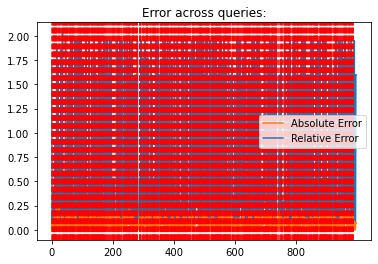

In [15]:
# Scenario 1
analysts = ['Alice', 'Bob']
randomAnalyst=analysts[np.random.randint(0, 2)]
workloads = {'Alice': s1alice_q, 'Bob': s1bob_q}
random_query = getRandomQuery(workloads[randomAnalyst])
print(f'{randomAnalyst=}')
print(f'random_query={list(random_query)}')

s1combined = pmw2(workload=np.vstack((s1alice_q, s1bob_q, np.array([getRandomQuery(workloads[randomAnalyst]) for i in range(950)]))), 
                  x=x_small, eps=2, T=40, k=10,  
                  analyst_labels=['Alice'] * 25 + ['Bob'] * 25 + [randomAnalyst] * 950, 
                  to_return='pd', 
                  show_plot=True, show_messages=False, show_failure_step=False)

print(f"Alice's avg error = {round(s1combined[s1combined.analyst=='Alice'].real_ans.mean(), 2)}")
print(f"Bob's avg error = {round(s1combined[s1combined.analyst=='Bob'].real_ans.mean(), 2)}")

In [16]:
s1combined

,algo_ans,real_ans,queries,updated,abs_error,rel_error,synthetic database,analyst,d_t_hat
0,0.12,0.04,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",no,0.08,1.75,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,-31.40
1,0.50,0.50,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",no,0.00,0.00,"[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1...",Alice,12.21
2,0.45,0.50,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",yes,0.05,0.09,"[0.124, 0.124, 0.124, 0.124, 0.126, 0.126, 0.1...",Alice,-20.49
3,0.37,0.46,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",no,0.08,0.18,"[0.124, 0.124, 0.124, 0.124, 0.126, 0.126, 0.1...",Alice,-7.49
4,0.48,0.50,"[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",yes,0.02,0.05,"[0.123, 0.123, 0.123, 0.123, 0.127, 0.127, 0.1...",Alice,-8.37
...,...,...,...,...,...,...,...,...,...
995,0.12,0.04,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",no,0.07,1.60,"[0.12, 0.131, 0.104, 0.106, 0.118, 0.17, 0.117...",Bob,-19.71
996,0.00,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",no,0.00,0.00,"[0.12, 0.131, 0.104, 0.106, 0.118, 0.17, 0.117...",Bob,-25.03
997,0.41,0.46,"[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]",no,0.05,0.11,"[0.12, 0.131, 0.104, 0.106, 0.118, 0.17, 0.117...",Bob,29.71
998,0.12,0.04,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",no,0.07,1.60,"[0.12, 0.131, 0.104, 0.106, 0.118, 0.17, 0.117...",Bob,-32.77


In [17]:
x_small/sum(x_small)

array([0.04545455, 0.36363636, 0.04545455, 0.04545455, 0.04545455,
       0.36363636, 0.04545455, 0.04545455])

randomAnalyst='Bob'
random_query=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
Alice's avg error = 0.51
Bob's avg error = 0.1


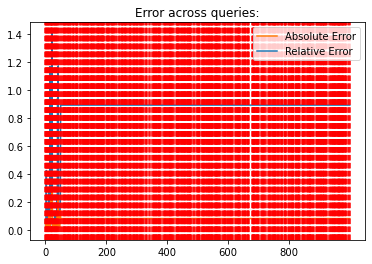

In [18]:
# Scenario 2
randomAnalyst=analysts[np.random.randint(0, 2)]
print(f'{randomAnalyst=}')
print(f'random_query={list(random_query)}')
s2combined = pmw2(workload=np.vstack((s2alice_q, s2bob_q, np.array([random_query for i in range(950)]))), 
                  x=x_small, eps=2, T=40, k=10, 
                  analyst_labels=['Alice'] * 25 + ['Bob'] * 25 + [randomAnalyst] * 950, 
                  to_return='pd', 
                  show_plot=True, show_messages=False, show_failure_step=False)

print(f"Alice's avg error = {round(s2combined[s2combined.analyst=='Alice'].real_ans.mean(), 2)}")
print(f"Bob's avg error = {round(s2combined[s2combined.analyst=='Bob'].real_ans.mean(), 2)}")

Interesting. When Bob's queries are stretched really far, he has less error than Alice. When Alice's queries are stretched really far, she has more error than Bob.

randomAnalyst='Bob'
random_query=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
Alice's avg error = 0.43
Bob's avg error = 0.09


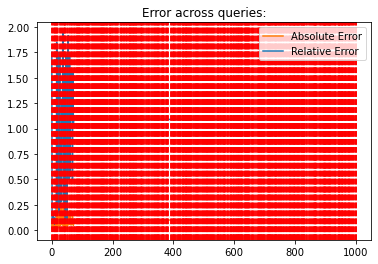

In [19]:
# Scenario 3
randomAnalyst=analysts[np.random.randint(0, 2)]
print(f'{randomAnalyst=}')
print(f'random_query={list(random_query)}')
s3combined = pmw2(workload=np.vstack((s3alice_q, s3bob_q, np.array([random_query for i in range(930)]))),
                  x=x_small, eps=2, T=40, k=10, 
                  analyst_labels=['Alice'] * 36 + ['Bob'] * 36 + [randomAnalyst] * 930, 
                  to_return='pd', 
                  show_plot=True, show_messages=False, show_failure_step=False)

print(f"Alice's avg error = {round(s3combined[s3combined.analyst=='Alice'].real_ans.mean(), 2)}")
print(f"Bob's avg error = {round(s3combined[s3combined.analyst=='Bob'].real_ans.mean(), 2)}")

Alice = all range

Bob = singleton

Alice has substantially more error than (.5 vs .11) Bob when her query is stretched far.

Bob only has a little bit more error (.49 vs .43) than Alice when his query is stretched far.

Perhaps all range queries are more susceptible to error on synthetic databases than singleton queries?

randomAnalyst='Bob'
random_query=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
Alice's avg error = 0.545
Bob's avg error = 0.103


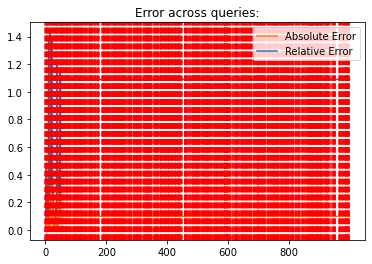

In [20]:
# Scenario 4
randomAnalyst=analysts[np.random.randint(0, 2)]
print(f'{randomAnalyst=}')
print(f'random_query={list(random_query)}')
s4combined = pmw2(workload=np.vstack((s4alice_q, s4bob_q, np.array([random_query for i in range(950)]))),
                  x=x_small, eps=2, T=40, k=10, 
                  analyst_labels=['Alice'] * 25 + ['Bob'] * 25 + [randomAnalyst] * 950, 
                  to_return='pd', 
                  show_plot=True, show_messages=False, show_failure_step=False)

print(f"Alice's avg error = {round(s4combined[s4combined.analyst=='Alice'].real_ans.mean(), 3)}")
print(f"Bob's avg error = {round(s4combined[s4combined.analyst=='Bob'].real_ans.mean(), 3)}")

Their errors are about the same, even when one of the analysts has their queries stretched really far out. Very interesting. This means that the synthetic database is doing a pretty good job. 

Moreover, the analyst that has their query stretched out actually ends up with less error than the analyst who didn't have their query stretched out. (0.505 > 0.5). I wonder why this is. 

# 10/26 Notes
- Do a new random query for all of the 950 queries. If too slow, then copy the entire workload over many times.
- Goal: show that very simple mechanisms don't have this bad behavior. 

### Cache and Reuse
- Algorithm.
    - For the first k queries that analysts ask, answer those queries using a constant fraction of the privacy budget. Once that's done, if someone else asks those same queries, you can output the answer that you already used. 
    - Privacy budget is split between Bob and Alice. 
        - What would've been null before is no longer null because Bob can piggy back off of Alice's answers. 
        - In the individual setting, they have 1 privacy budget. In the joint setting, they each have 1 privacy budget. Alice can't eat into Bob's privacy budget. They own their own resources, but they can collaborate s.t. no one is worse off. 
    - After you use all the privacy budget, you respond with null if it's a query that you haven't seen before. 

- What to look for: 
    - With the same settings, show that joint version has less error than individual error. It won't fail the sharing incentive. Measure this in both total error and total number of queries answers. 

Psuedo code: 
- If k doesn't equal 0
    - answer the query using laplace mechanism
    - calculate error 
    - append to error list
    - decrement k
- If k equals 0
    - append null to the error list
    - return error list

In [21]:
query = np.random.randint(2, size=(11,8))[0] 
storage = {}

def cache(query, storage, ans, error):
    """caches query into a dictionary with values of (ans, error)"""
    storage[np.array2string(query)] = (ans, error)
    return storage
    
def is_reusable(query, storage):
    """returns whether or not a query is in a strategy matrix 
    (cache)"""
    return np.array2string(query) in storage

def reuse(query, storage):
    """returns tuple with (query answer, error) stored in 
    a storage dictionary"""
    return storage[np.array2string(query)]
    

cache(query, storage, 0.5, 0.5)
is_reusable(query, storage)
reuse(query, storage)

(0.5, 0.5)

In [22]:
def cache_and_reuse(workload, x, eps=0.01, k=0, analyst_labels=[]):
    """
    Takes in workload, database, eps (privacy budget), k (number of total update steps PER ANALYST). 
    
    Returns list of error per query.
    """
    budgets = {}
    for analyst in list(set(analyst_labels)): 
        budgets[analyst] = k # each analyst starts with k update stepss
    
    error_list = []
    ans_list = []
    updated_list = []
    used_cache_list = []
    
    n = x_small.sum()
    x_norm = x_small/sum(x_small)
    storage = {}
    for i, query in enumerate(workload): 
        analyst = analyst_labels[i]
        if is_reusable(query, storage): # this analyst' query has been asked before and can be reused
            noisy_ans, abs_error = reuse(query, storage)
            
            error_list.append(abs_error)
            ans_list.append(noisy_ans)
            updated_list.append(False)
            used_cache_list.append(True)
        elif budgets[analyst] != 0: # this analyst still has update steps left
            noise = np.random.laplace(0, k/(n * eps), 1)[0]
            noisy_ans = (np.dot(query, x_norm)) + noise
            true_ans = np.matmul(query, x_norm)
            abs_error = np.abs(noisy_ans - true_ans)
            error_list.append(abs_error)
            budgets[analyst] -= 1
            storage = cache(query, storage, noisy_ans, abs_error)
            
            updated_list.append(True)
            ans_list.append(noisy_ans)
            used_cache_list.append(False)
        elif budgets[analyst] == 0: # this analyst has run out of update steps
            error_list.append(None)
            ans_list.append(None)
            updated_list.append(False)
            used_cache_list.append(False)
    d = {'queries': workload.tolist(), 
        'abs_error': error_list,
        'ans': ans_list,
        'updated': updated_list,
        'used_cache': used_cache_list,
        #'abs_error': abs_error,               
        #'rel_error': rel_error,
        #'synthetic database': x_list,
        'analyst': analyst_labels,
        #'d_t_hat': d_t_hat_list, 
    }
    test_data = pd.DataFrame(data=d)
    test_data = test_data.round(3)
    test_data['isNa'] = np.where(test_data.abs_error.isnull(), True, False)
    return test_data

random_workload = np.random.randint(2, size=(11,8))

In [23]:
def cache_experiment_s1(trials, function='reuse'):
    """scenario 1"""
    num_q_unanswered = dict.fromkeys(['alice_joint', 'bob_joint', 'alice_ind', 'bob_ind'], 0)
    abs_error_dict = dict.fromkeys(['alice_joint', 'bob_joint', 'alice_ind', 'bob_ind'], 0)

    for i in range(trials):
        s1random_array = np.random.randint(2, size=(25,4))
        s1alice_q = np.hstack((s1random_array, s1zero_array))
        s1bob_q = np.hstack((s1zero_array, s1random_array))
        
        if function=='reuse':
            s1_cr_ab = cache_and_reuse(np.vstack((s1alice_q, s1bob_q)), x_small, eps=2, k=10, analyst_labels=['Alice'] * 25 + ['Bob'] * 25)
        else:
            s1_cr_ab = cache_and_reconstruct(np.vstack((s1alice_q, s1bob_q)), x_small, eps=2, k=10, analyst_labels=['Alice'] * 25 + ['Bob'] * 25)
            
        num_q_unanswered['alice_joint'] += (~s1_cr_ab[s1_cr_ab.analyst=='Alice'].isNa).sum()
        num_q_unanswered['bob_joint'] += (~s1_cr_ab[s1_cr_ab.analyst=='Bob'].isNa).sum()
        abs_error_dict['alice_joint'] += s1_cr_ab[s1_cr_ab.analyst=='Alice'].abs_error.sum()
        abs_error_dict['bob_joint'] += s1_cr_ab[s1_cr_ab.analyst=='Bob'].abs_error.sum()

        if function=='reuse':
            s1_cr_a = cache_and_reuse(s1alice_q, x_small, eps=2, k=10, analyst_labels=['Alice'] * 25)
        else: 
            s1_cr_a = cache_and_reconstruct(s1alice_q, x_small, eps=2, k=10, analyst_labels=['Alice'] * 25)

        num_q_unanswered['alice_ind'] += (~s1_cr_a.isNa).sum()
        abs_error_dict['alice_ind'] += s1_cr_a.abs_error.sum()

        if function=='reuse':
            s1_cr_b = cache_and_reuse(s1bob_q, x_small, eps=2, k=10, analyst_labels=['Bob'] * 25)
        else: 
            s1_cr_b = cache_and_reconstruct(s1bob_q, x_small, eps=2, k=10, analyst_labels=['Bob'] * 25)
        num_q_unanswered['bob_ind'] += (~s1_cr_b.isNa).sum()
        abs_error_dict['bob_ind'] += s1_cr_b.abs_error.sum()


    avg_q_ans = {k: v / trials for k, v in num_q_unanswered.items()}
    avg_abs_error = {k: round(v / trials, 2) for k, v in abs_error_dict.items()}

    #visualization
    display(pd.DataFrame([avg_abs_error, avg_q_ans], index=['Total Absolute Error', '# Queries Answered']))

cache_experiment_s1(100)

,alice_joint,bob_joint,alice_ind,bob_ind
Total Absolute Error,0.25,0.25,0.24,0.28
# Queries Answered,21.72,22.46,21.72,21.72


Bob can answer more queries in the joint case than in the individual case. 

In [24]:
def cache_experiment_s2(trials, function='reuse'):
    num_q_unanswered = dict.fromkeys(['alice_joint', 'bob_joint', 'alice_ind', 'bob_ind'], 0)
    abs_error_dict = dict.fromkeys(['alice_joint', 'bob_joint', 'alice_ind', 'bob_ind'], 0)

    for i in range(trials):
        s2alice_q = np.hstack((np.random.randint(2, size=(25,7)), np.zeros((25,1))))
        s2bob_q = np.random.randint(2, size=(25,8))

        if function=='reuse':
            s2_cr_ab = cache_and_reuse(np.vstack((s2alice_q, s2bob_q)), x_small, eps=2, k=10, analyst_labels=['Alice'] * 25 + ['Bob'] * 25)
        else: 
            s2_cr_ab = cache_and_reconstruct(np.vstack((s2alice_q, s2bob_q)), x_small, eps=2, k=10, analyst_labels=['Alice'] * 25 + ['Bob'] * 25)
        
        num_q_unanswered['alice_joint'] += (~s2_cr_ab[s2_cr_ab.analyst=='Alice'].isNa).sum()
        num_q_unanswered['bob_joint'] += (~s2_cr_ab[s2_cr_ab.analyst=='Bob'].isNa).sum()
        abs_error_dict['alice_joint'] += s2_cr_ab[s2_cr_ab.analyst=='Alice'].abs_error.sum()
        abs_error_dict['bob_joint'] += s2_cr_ab[s2_cr_ab.analyst=='Bob'].abs_error.sum()
        
        if function=='reuse':
            s2_cr_a = cache_and_reuse(s2alice_q, x_small, eps=2, k=10, analyst_labels=['Alice'] * 25)
        else: 
            s2_cr_a = cache_and_reconstruct(s2alice_q, x_small, eps=2, k=10, analyst_labels=['Alice'] * 25)
        num_q_unanswered['alice_ind'] += (~s2_cr_a.isNa).sum()
        abs_error_dict['alice_ind'] += s2_cr_a.abs_error.sum()

        if function=='reuse':
            s2_cr_b = cache_and_reuse(s2bob_q, x_small, eps=2, k=10, analyst_labels=['Bob'] * 25)
        else: 
            s2_cr_b = cache_and_reconstruct(s2bob_q, x_small, eps=2, k=10, analyst_labels=['Bob'] * 25)
        num_q_unanswered['bob_ind'] += (~s2_cr_b.isNa).sum()
        abs_error_dict['bob_ind'] += s2_cr_b.abs_error.sum()


    avg_q_ans = {k: v / trials for k, v in num_q_unanswered.items()}
    avg_abs_error = {k: round(v / trials, 2) for k, v in abs_error_dict.items()}

    #visualization
    display(pd.DataFrame([avg_abs_error, avg_q_ans], index=['Total Absolute Error', '# Queries Answered']))

cache_experiment_s2(100, function='reuse')

,alice_joint,bob_joint,alice_ind,bob_ind
Total Absolute Error,0.13,0.14,0.13,0.12
# Queries Answered,11.59,11.59,11.59,10.71


Bob is able to answer slightly less queries in the independent case than in the joint case. 

In [25]:
# Let Alice be the singleton asker, and Bob be the all range asker in this case: 

def cache_experiment_s3(trials, function='reuse'):
    num_q_unanswered = dict.fromkeys(['alice_joint', 'bob_joint', 'alice_ind', 'bob_ind'], 0)
    abs_error_dict = dict.fromkeys(['alice_joint', 'bob_joint', 'alice_ind', 'bob_ind'], 0)

    for i in range(trials):
        lst = [[0] * 8 for i in range(36)]
        for i in range(len(lst)):
            lst[i][np.random.randint(0, 8)] = 1
        s3alice_q = np.array(lst)
        s3bob_q = AllRange(8).dense_matrix()
        if function=='reuse':
            s3_cr_ab = cache_and_reuse(np.vstack((s3alice_q, s3bob_q)), x_small, eps=2, k=10, analyst_labels=['Alice'] * 36 + ['Bob'] * 36)
        else: 
            s3_cr_ab = cache_and_reconstruct(np.vstack((s3alice_q, s3bob_q)), x_small, eps=2, k=10, analyst_labels=['Alice'] * 36 + ['Bob'] * 36)

        num_q_unanswered['alice_joint'] += (~s3_cr_ab[s3_cr_ab.analyst=='Alice'].isNa).sum()
        num_q_unanswered['bob_joint'] += (~s3_cr_ab[s3_cr_ab.analyst=='Bob'].isNa).sum()
        abs_error_dict['alice_joint'] += s3_cr_ab[s3_cr_ab.analyst=='Alice'].abs_error.sum()
        abs_error_dict['bob_joint'] += s3_cr_ab[s3_cr_ab.analyst=='Bob'].abs_error.sum()

        if function=='reuse':
            s3_cr_a = cache_and_reuse(s3alice_q, x_small, eps=2, k=10, analyst_labels=['Alice'] * 36)
        else: 
            s3_cr_a = cache_and_reconstruct(s3alice_q, x_small, eps=2, k=10, analyst_labels=['Alice'] * 36)

        num_q_unanswered['alice_ind'] += (~s3_cr_a.isNa).sum()
        abs_error_dict['alice_ind'] += s3_cr_a.abs_error.sum()

        if function=='reuse':
            s3_cr_b = cache_and_reuse(s3bob_q, x_small, eps=2, k=10, analyst_labels=['Bob'] * 36)
        else: 
            s3_cr_b = cache_and_reconstruct(s3bob_q, x_small, eps=2, k=10, analyst_labels=['Bob'] * 36)

        num_q_unanswered['bob_ind'] += (~s3_cr_b.isNa).sum()
        abs_error_dict['bob_ind'] += s3_cr_b.abs_error.sum()


    avg_q_ans = {k: v / trials for k, v in num_q_unanswered.items()}
    avg_abs_error = {k: round(v / trials, 2) for k, v in abs_error_dict.items()}

    #visualization
    display(pd.DataFrame([avg_abs_error, avg_q_ans], index=['Total Absolute Error', '# Queries Answered']))

cache_experiment_s3(1)

,alice_joint,bob_joint,alice_ind,bob_ind
Total Absolute Error,0.46,0.26,0.48,0.09
# Queries Answered,36.00,17.00,36.00,10.00


Bob can ask 10 queries using the update steps and 8 from reusing Alice's singletons 

In [26]:
def cache_experiment_s4(trials, function='reuse'):
    num_q_unanswered = dict.fromkeys(['alice_joint', 'bob_joint', 'alice_ind', 'bob_ind'], 0)
    abs_error_dict = dict.fromkeys(['alice_joint', 'bob_joint', 'alice_ind', 'bob_ind'], 0)

    for i in range(trials):
        s4alice_q = np.random.randint(2, size=(25,8))
        s4bob_q = s4alice_q

        if function=='reuse':
            s4_cr_ab = cache_and_reuse(np.vstack((s4alice_q, s4bob_q)), x_small, eps=2, k=10, analyst_labels=['Alice'] * 25 + ['Bob'] * 25)
        else: 
            s4_cr_ab = cache_and_reconstruct(np.vstack((s4alice_q, s4bob_q)), x_small, eps=2, k=10, analyst_labels=['Alice'] * 25 + ['Bob'] * 25)

        num_q_unanswered['alice_joint'] += (~s4_cr_ab[s4_cr_ab.analyst=='Alice'].isNa).sum()
        num_q_unanswered['bob_joint'] += (~s4_cr_ab[s4_cr_ab.analyst=='Bob'].isNa).sum()
        abs_error_dict['alice_joint'] += s4_cr_ab[s4_cr_ab.analyst=='Alice'].abs_error.sum()
        abs_error_dict['bob_joint'] += s4_cr_ab[s4_cr_ab.analyst=='Bob'].abs_error.sum()

        if function=='reuse':
            s4_cr_a = cache_and_reuse(s4alice_q, x_small, eps=2, k=10, analyst_labels=['Alice'] * 25)
        else: 
            s4_cr_a = cache_and_reconstruct(s4alice_q, x_small, eps=2, k=10, analyst_labels=['Alice'] * 25)

        num_q_unanswered['alice_ind'] += (~s4_cr_a.isNa).sum()
        abs_error_dict['alice_ind'] += s4_cr_a.abs_error.sum()

        if function=='reuse':
            s4_cr_b = cache_and_reuse(s4bob_q, x_small, eps=2, k=10, analyst_labels=['Bob'] * 25)
        else:
            s4_cr_b = cache_and_reconstruct(s4bob_q, x_small, eps=2, k=10, analyst_labels=['Bob'] * 25)

        num_q_unanswered['bob_ind'] += (~s4_cr_b.isNa).sum()
        abs_error_dict['bob_ind'] += s4_cr_b.abs_error.sum()


    avg_q_ans = {k: v / trials for k, v in num_q_unanswered.items()}
    avg_abs_error = {k: round(v / trials, 2) for k, v in abs_error_dict.items()}

    #visualization
    display(pd.DataFrame([avg_abs_error, avg_q_ans], index=['Total Absolute Error', '# Queries Answered']))

cache_experiment_s4(100)

,alice_joint,bob_joint,alice_ind,bob_ind
Total Absolute Error,0.12,0.24,0.13,0.12
# Queries Answered,10.74,21.12,10.74,10.74


Bob can ask exactly double because he is able to conserve his own update steps by using the query answers that Alice answered for him. 

# To-do's (11/9): 
- For generating workloads, don't allow repeated queries to be asked in a workload.
- Implement average error. 
- Implement the number of times we cannot answer the query
- Try to expand this to cache and reconstruct - essentially replace reuse with reconstruct. 

Reconstruction step: 

reconstruction - i don't have this exact query, but the sum of queries i already have might be the answer you are looking for. 

Reconstruction step is already pre-coded. There is a function in the matrix mechanism files that is the expected error of a workload. Store your cache in matrix form. takes a workload, strategy A, and an epsilon, and gives you an expected error. 

Workload would be single query

Strategy of all the queries that have been saved in the cache

eps you use for the function = n / k * epsilon, where n = # of queries in the strategy matrix, k = is the total number of update steps across all analysts. (take a look at the hdmm paper if you still want to learn)


### Nov 12 Progress

In [27]:
s1random_array = np.random.randint(2, size=(25,4))
s1alice_q = np.hstack((s1random_array, s1zero_array))

print(s1alice_q[0:1])
print(s1alice_q)

print(expected_error(s1alice_q, s1alice_q[0:1], eps = 1))
print(expected_error(s1alice_q, s1alice_q[0:1], eps = 100))

[[1. 1. 1. 0. 0. 0. 0. 0.]]
[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]]
19.999999999999986
0.0019999999999999987


Realistically the error should be zero for this query, because the query is literally drawn from the first query in the strategy matrix. Not sure why the error is a positive number. 

However, the behavior of error decreasing when epsilon approaches infinity is accurate in this case. 

In [28]:
# indexing on separate parts of the array: 
expected_error(s1bob_q[0:1], s1alice_q)

0.0

In [29]:
a = np.array([[1, 1, 1]])
b = np.array([[1, 1, 1]])
np.concatenate((a, b), axis = 0)

array([[1, 1, 1],
       [1, 1, 1]])

In [30]:
np.expand_dims(a, axis=0)

array([[[1, 1, 1]]])

eps you use for the function = n / k * epsilon, where n = # of queries in the strategy matrix, k = is the total number of update steps across all analysts. (take a look at the hdmm paper if you still want to learn)

In [31]:
def add_to_strategy(query, strategy):
    """Append query to the end fo the strategy matrix"""
    return np.concatenate((strategy, query), axis = 0)

def cache_and_reconstruct(workload, x, eps=0.01, k=0, analyst_labels=[]):
    """
    Takes in workload, database, eps (privacy budget), k (number of total update steps PER ANALYST). 
    
    Returns list of error per query.
    """
    budgets = {}
    for analyst in list(set(analyst_labels)): 
        budgets[analyst] = k # each analyst starts with k update steps
    
    numAnalysts = len(budgets)
    error_list = []
    updated_list = []
    used_reconstruct_list = []
    
    n = x_small.sum()
    x_norm = x_small/sum(x_small) # normalize database
    strategy = workload[0 : 1]
    for i, query in enumerate(workload): 
        query = np.expand_dims(query, axis = 0)
        analyst = analyst_labels[i]
        
        if budgets[analyst] != 0: # this analyst still has update steps left
            noise = np.random.laplace(0, (k * numAnalysts) / (n * eps), 1)[0]
            noisy_ans = (np.dot(query, x_norm)) + noise
            true_ans = np.matmul(query, x_norm)
            error_list.append(np.abs(noisy_ans - true_ans)[0] * n) 
            budgets[analyst] -= 1 
            if i != 0:
                strategy = add_to_strategy(query, strategy)
            
            updated_list.append(True)
            used_reconstruct_list.append(False)
            
        elif strategy_supports_workload(EkteloMatrix(query), EkteloMatrix(strategy)): # how to convert numpy array to ektelo matrix https://github.com/yikai-wu/Multi-Analyst-DP/blob/fadc7ac1d20199e8b31914f44323e51a05ed072d/src/hdmm/matrix.py#L34
            
            abs_error = expected_error(query, strategy, eps = len(strategy) / (k * numAnalysts) * eps) # do i mult by 100
            
            error_list.append(abs_error)
            updated_list.append(False)
            used_reconstruct_list.append(True) 
            
        elif budgets[analyst] == 0: # this analyst has run out of update steps
            error_list.append(None)
            updated_list.append(False)
            used_reconstruct_list.append(False)
        
            
    d = {'queries': workload.tolist(), 
        'abs_error': error_list,
        'updated': updated_list,
        'used_reconstruct': used_reconstruct_list,
        'analyst': analyst_labels,
    }
    test_data = pd.DataFrame(data=d)
    test_data = test_data.round(3)
    test_data['isNa'] = np.where(test_data.abs_error.isnull(), True, False)
    return test_data

random_workload = np.random.randint(2, size=(11,8))

In [32]:
cache_and_reuse(np.vstack((s1alice_q, s1bob_q)), x_small, eps=2, k=10, 
                      analyst_labels=['Alice'] * 25 + ['Bob'] * 25)

,queries,abs_error,ans,updated,used_cache,analyst,isNa
0,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.00,0.45,True,False,Alice,False
1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.00,0.37,True,False,Alice,False
2,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",0.02,0.11,True,False,Alice,False
3,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,0.03,True,False,Alice,False
4,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",0.01,0.46,True,False,Alice,False
5,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.00,0.37,False,True,Alice,False
6,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.00,0.45,False,True,Alice,False
7,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,0.06,True,False,Alice,False
8,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",0.02,0.11,False,True,Alice,False
9,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",0.01,0.46,False,True,Alice,False


In [33]:
s1random_array = np.random.randint(2, size=(25,4))
s1alice_q = np.hstack((s1random_array, s1zero_array))
s1bob_q = np.hstack((s1zero_array, s1random_array))

cache_and_reconstruct(np.vstack((s1alice_q, s1bob_q)), x_small, eps=2, k=10, 
                      analyst_labels=['Alice'] * 25 + ['Bob'] * 25)

,queries,abs_error,updated,used_reconstruct,analyst,isNa
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",11.21,True,False,Alice,False
1,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",6.63,True,False,Alice,False
2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",9.51,True,False,Alice,False
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.78,True,False,Alice,False
4,"[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.51,True,False,Alice,False
5,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",19.34,True,False,Alice,False
6,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7.36,True,False,Alice,False
7,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",19.77,True,False,Alice,False
8,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",9.80,True,False,Alice,False
9,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",5.67,True,False,Alice,False


# Long-term To-do's (11/9):
Results: 
- Look at Yikai’s papers to see how to structure the results of your experiments for the papers.
- Toy results (shown in the definition), larger evaluations (testing efficacy on larger experiments on the cluster. Datasets like this don’t work. Make a stochastic process for generating these sets) 
- Try to get these done in Janurary. 


# 11/12 To-do's: 
- [done] Fix cache and reconstruct cache epsilon step
- [done] Run cache and reconstruct on all settings
- [done] New implementation of PMW with splitting budget 

# 11/17 to do's: 
- Add old PMW as well
- call new one shared_PMW
- Run experiments for reconstruct and shared PMW
    - see if shared PMW meets non-interference and sharing desiderata